# Simple Numpy NN from Scratch

This code was created by Samson Zhang, you can find the original code here: [simple-mnist-nn-from-scratch](https://www.kaggle.com/code/wwsalmon/simple-mnist-nn-from-scratch-numpy-no-tf-keras/notebook)

In this notebook, I implemented a simple two-layer neural network and trained it on the MNIST digit recognizer dataset. It's meant to be an instructional example, through which you can understand the underlying math of neural networks better.

Here's a video I made explaining all the math and showing my progress as I coded the network: [Building a neural network FROM SCRATCH](https://youtu.be/w8yWXqWQYmU)

In [47]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [48]:
data = pd.read_csv('./digit-recognizer/train.csv')

In [49]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

train_data = data[1000:m].T
Y_train = train_data[0]
X_train = train_data[1:n]
X_train = X_train / 255.
_, m_train = X_train.shape

val_data = data[0:1000].T
Y_val = val_data[0]
X_val = val_data[1:n]
X_val = X_val / 255.

In [50]:
Y_train

array([5, 8, 0, ..., 6, 7, 7])

Our NN will have a simple two-layer architecture. Input layer $A^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $A^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $A^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.


**Forward propagation**

Input Layer:    
$$X = A^{[0]}$$

First Hidden Layer:
$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]})$$

Second Hidden Layer:
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

Loss Function (Categorical Cross Entropy):  
$$L(y, a^{[2]}) = -\sum_{j = 1}^{C}y_{j} \cdot\ log(a^{[2]})$$ 
C is the number of classes, which is 10 in this case. 

Cost Function:
$$J(W, b) = \frac{1}{m} \sum_{i = 1}^{m} L(y^{i}, a^{[2](i)})$$ 
$$J(W, b) = \frac{1}{m} \sum_{i = 1}^{m} \sum_{j = 1}^{C}y^{i}_{j}\cdot\log(a^{[2](i)})$$ 
The cost function is the average of the losses over all the samples.

Derivatives:    
For detailed derivation of $dZ^{[2]}$ see: [derivation-of-categorical-cross-entropy-loss](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1)    
For more details on the rest of the derivations see: [backpropagation-intuition](https://www.youtube.com/watch?v=yXcQ4B-YSjQ&list=PLkDaE6sCZn6Ec-XTbcX1uRg2_u4xOEky0&index=34&ab_channel=DeepLearningAI)
$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \sum_{i = 1}^{m} {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \sum_{i = 1}^{m} {dZ^{[1]}}$$

**Gradient Descent (parameter updates)**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [51]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [52]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [53]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[2 2 2 ... 2 9 2] [5 8 0 ... 6 7 7]
0.10526829268292683
Iteration:  10
[3 7 3 ... 9 9 9] [5 8 0 ... 6 7 7]
0.24490243902439024
Iteration:  20
[3 7 3 ... 9 7 0] [5 8 0 ... 6 7 7]
0.39821951219512197
Iteration:  30
[2 7 3 ... 8 7 0] [5 8 0 ... 6 7 7]
0.480390243902439
Iteration:  40
[1 7 0 ... 8 7 0] [5 8 0 ... 6 7 7]
0.5335609756097561
Iteration:  50
[1 7 0 ... 8 7 2] [5 8 0 ... 6 7 7]
0.5762926829268292
Iteration:  60
[1 7 0 ... 8 7 2] [5 8 0 ... 6 7 7]
0.6113170731707317
Iteration:  70
[1 7 0 ... 8 7 2] [5 8 0 ... 6 7 7]
0.6398292682926829
Iteration:  80
[1 3 0 ... 8 7 2] [5 8 0 ... 6 7 7]
0.6642682926829269
Iteration:  90
[1 3 0 ... 8 7 2] [5 8 0 ... 6 7 7]
0.6830731707317074
Iteration:  100
[1 3 0 ... 8 7 2] [5 8 0 ... 6 7 7]
0.6979756097560975
Iteration:  110
[1 3 0 ... 6 7 2] [5 8 0 ... 6 7 7]
0.710170731707317
Iteration:  120
[1 3 0 ... 6 7 2] [5 8 0 ... 6 7 7]
0.721780487804878
Iteration:  130
[1 3 0 ... 6 7 2] [5 8 0 ... 6 7 7]
0.7315609756097561
Iteration:  140
[

~85% accuracy on training set.

In [54]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Let's look at a couple of examples:

Prediction:  [1]
Label:  5


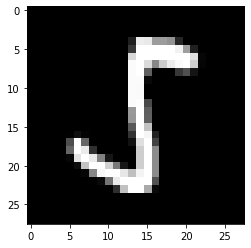

Prediction:  [3]
Label:  8


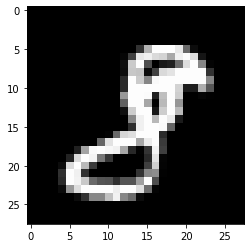

Prediction:  [0]
Label:  0


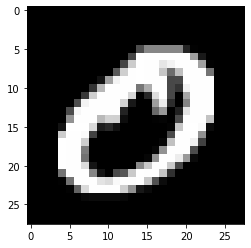

Prediction:  [4]
Label:  4


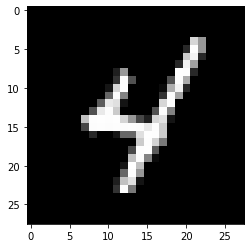

In [55]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

Finally, let's find the accuracy on the val set:

In [56]:
val_predictions = make_predictions(X_val, W1, b1, W2, b2)
get_accuracy(val_predictions, Y_val)

[1 9 7 6 8 7 6 0 8 8 1 9 9 9 4 6 1 5 6 9 4 4 0 1 2 2 2 1 5 3 8 4 4 6 6 0 2
 6 2 7 9 6 4 2 2 5 5 2 5 1 0 1 9 1 5 3 4 8 1 2 6 8 1 1 0 3 4 2 9 8 0 9 6 3
 3 7 7 6 1 5 4 1 2 7 6 1 9 4 0 3 8 1 4 5 7 9 5 9 9 5 9 9 2 4 8 8 4 1 0 4 6
 4 8 1 5 6 4 5 1 7 9 1 6 8 5 5 1 7 7 1 0 4 3 9 1 9 0 8 1 4 0 5 3 7 7 5 8 7
 2 4 2 8 1 3 4 2 4 5 2 1 3 8 3 6 2 2 7 7 2 5 4 2 5 1 6 4 7 6 3 1 0 4 1 7 9
 4 3 4 8 3 4 5 9 0 1 6 1 7 5 7 3 9 2 1 9 1 5 1 4 8 9 8 4 3 4 2 7 2 0 0 5 0
 1 7 1 0 2 1 6 5 0 9 5 0 7 0 6 1 7 0 9 8 4 0 9 6 1 8 1 7 8 7 7 8 9 9 8 7 1
 4 1 3 3 6 3 8 2 3 5 2 0 0 6 0 2 6 2 7 7 9 8 1 1 2 0 6 4 1 4 6 9 9 5 7 1 7
 1 2 5 2 4 4 8 0 1 0 7 4 6 1 8 9 6 4 7 6 7 8 1 4 3 9 6 9 5 7 1 6 6 9 9 8 0
 0 4 4 9 0 0 4 9 5 2 6 7 4 6 5 4 7 3 0 7 3 0 5 6 7 6 6 2 8 1 2 1 4 4 0 7 5
 9 6 0 7 7 1 6 8 2 5 5 7 1 6 1 6 7 5 4 8 5 4 4 1 4 4 6 4 1 4 0 5 4 0 8 1 1
 0 9 8 7 0 8 0 7 0 5 9 8 7 4 2 7 1 3 3 1 7 3 6 4 9 8 4 4 6 4 1 5 8 0 8 9 5
 0 6 4 2 1 0 8 9 7 7 1 6 4 3 1 0 3 1 1 0 3 0 4 6 2 4 4 1 5 0 4 1 7 3 8 9 6
 1 2 8 8 3 2 5 4 6 9 3 9 

0.813

Still 84% accuracy, so our model generalized from the training data pretty well.

In [73]:
large_X_input = X_val.copy()

for i in range(6):
    large_X_input = np.concatenate((large_X_input, large_X_input), axis=1)


In [76]:
large_X_input.shape

(784, 64000)

In [75]:
%timeit forward_prop(W1, b1, W2, b2, large_X_input)

75 ms ± 8.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
